In [85]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import (
    DataStore,
    FixedPointingInfo,
    Observation,
    observatory_locations,
)
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    EBLAbsorptionNormSpectralModel,
    TemplateSpectralModel
)
from gammapy.catalog import CATALOG_REGISTRY
from astropy.io import ascii

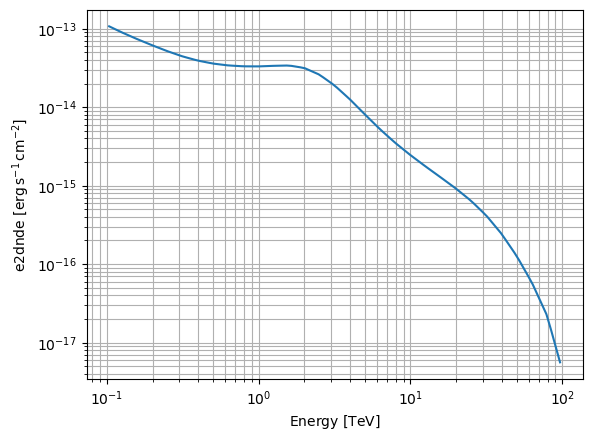

In [86]:
# Source
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

# Template spectral model. Defined by custom tabular values from Peretti+ 2023
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Peretti_2023_UFO.dat")

energy = data['Energy[MeV]'] *u.MeV
values = data['flux[MeV^-1cm^-2s^-1]'] *1.0 / (u.MeV * u.cm **2.0 * u.s)

spectral_model = TemplateSpectralModel(energy=energy, values=values)

spatial_model = PointSpatialModel.from_position(target_position)

sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=spatial_model,
                    name="NGC_1068",
                    )

# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

# Plotting the model
energy_bounds = [0.1, 100] * u.TeV
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts)
plt.grid(which="both")

In [87]:
# Define the full model
models = Models([sky_model, bkg_model])
print(models)

# save it to disk
file_model = "./UFO_NGC_1068.yaml"
models.write(file_model, write_covariance=False, overwrite=True)

irf_filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
IRF = load_irf_dict_from_file(irf_filename)

# this is a dictionary with the IRF extensions:
IRF

Models

Component 0: SkyModel

  Name                      : NGC_1068
  Datasets names            : None
  Spectral model type       : TemplateSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    lon_0                         :     40.669   +/-    0.00 deg         
    lat_0                         :     -0.013   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x17d19c510>,
 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF at 0x17d056990>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x17d21b690>,
 'bkg': <gammapy.irf.background.Background3D at 0x175cbd710>}

In [88]:
livetime = 475 * u.hr              #observation time with units
obs_id = "0001"                   # obs_id could be everything

pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(40.169 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg"),
)

location = observatory_locations["cta_north"]

reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc")
observation = Observation.create(
                        obs_id=obs_id, 
                        pointing=pointing, 
                        livetime=livetime, 
                        irfs=IRF,
                        location=location,
                        reference_time = reference_time, 
                        tstart = 30 * u.min
              )                                   
print(observation)

Observation

	obs id            : 0001 
 	tstart            : 61188.02
	tstop             : 61207.81
	duration          : 1710000.00 s
	pointing (icrs)   : 40.2 deg, -0.0 deg

	deadtime fraction : 0.0%



In [89]:
#Ereco ed Etrue must to be different: Etrue must have a larger range in order to reconstruct in the correct way (knowledge of
#the whole photon energy extension)

energy_axis = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=10, per_decade=True
    )

# for the Edisp
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "200 TeV", nbin=20, per_decade=True, name="energy_true"
    )

migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra" #If node_type = ‘edge’ then bounds correspond to the lower
                                                      #  and upper bound of the first and last bin.
    )    

# let's define the geometry of the simulation:
geom = WcsGeom.create(
    skydir=pointing.fixed_icrs,           
    width=(4, 4),         # gammapy uses a square not a circle 
    binsz=0.02,           # pixel size
    frame="icrs",
    axes=[energy_axis],    #in reco energy
)
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (np.int64(200), np.int64(200), 30)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 40.2 deg, -0.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 40.2 deg, -0.0 deg



In [90]:
#### MapDataset object with zer0-filled map
empty = MapDataset.create(
        geom,                               
        energy_axis_true=energy_axis_true,       #for the IRF maps
        migra_axis=migra_axis,                   #for the Edisp map
        name="my-dataset",                       #the name that will read the FoVBKG
            )

### Make maps for a single observation
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"]) #which maps to make (by default all)
dataset = maker.run(empty, observation)    #object

dataset.models = models

print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 23542000.39
  Total excess counts             : -23542000.39

  Predicted counts                : 23543454.90
  Predicted background counts     : 23542000.39
  Predicted excess counts         : 1454.51

  Exposure min                    : 1.49e+07 m2 s
  Exposure max                    : 2.86e+12 m2 s

  Number of total bins            : 1200000 
  Number of fit bins              : 1200000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 47086909.81

  Number of models                : 2 
  Number of parameters            : 5
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : NGC_1068
    Datasets names            : None
    Spectral model type       : TemplateSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parame

In [91]:
#define the seed of random number generator 
seed=0

#simulate
sampler = MapDatasetEventSampler(random_state=seed)
events = sampler.run(dataset, observation)

The meta information will be empty here.


In [92]:
events.table

TIME,ENERGY_TRUE,RA_TRUE,DEC_TRUE,ENERGY,RA,DEC,MC_ID,EVENT_ID,DETX,DETY
s,TeV,deg,deg,TeV,deg,deg,,,deg,deg
float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64
1799.9999999999984,0.1242993556779235,38.983498521419605,-0.7542756064526435,0.1242993556779235,38.983498521419605,-0.7542756064526435,0,7939382,-1.1854979681099647,-0.741278389082932
1799.9999999999984,0.15385112264869516,38.920733120775665,1.6729240637543012,0.15385112264869516,38.920733120775665,1.6729240637543012,0,4150308,-1.2482751826441894,1.6859209786582243
1800.0783955255208,0.24502213929300037,41.48467050173416,-0.25300390985228993,0.24502213929300037,41.48467050173416,-0.25300390985228993,0,6176176,1.3156692175232405,-0.24000733707917576
1800.1046519873528,0.1443558880691484,42.132694157823025,-0.3649469880953241,0.1443558880691484,42.132694157823025,-0.3649469880953241,0,9883922,1.9636913709201795,-0.35195462245568865
1800.3319037799351,0.2966893985553426,41.911963821132495,-0.35200334496191893,0.2966893985553426,41.911963821132495,-0.35200334496191893,0,18574997,1.7429614367249906,-0.3390093596172789
1800.3375624876262,0.11724307361534701,40.12023552409974,-0.29123092834952385,0.11724307361534701,40.12023552409974,-0.29123092834952385,0,12925643,-0.048764420915822955,-0.27823093305793845
1800.467815508058,0.19376577437508574,41.55575973557297,-0.8018864011954986,0.19376577437508574,41.55575973557297,-0.8018864011954986,0,17306393,1.3867553677671145,-0.7888902087661089
1800.5027103815833,0.11495340197140064,38.189262056792536,0.56423913782981,0.11495340197140064,38.189262056792536,0.56423913782981,0,8366154,-1.9797424169288134,0.5772313781951619


In [93]:
print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")

Source events: 1496
Background events: 23544589


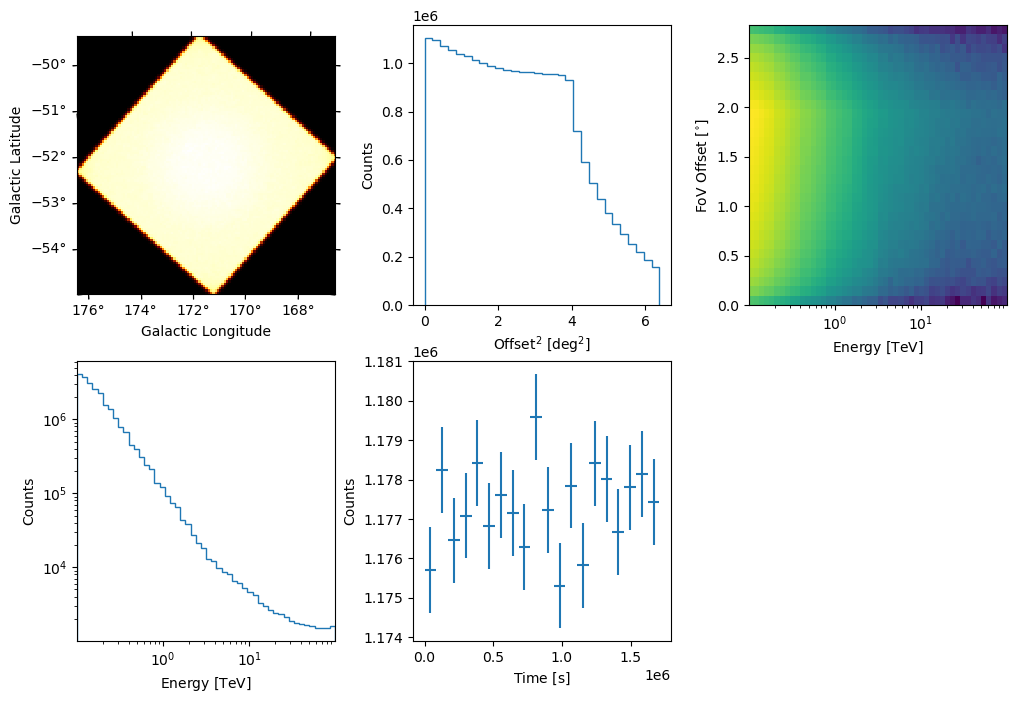

In [94]:
# let's have a look at the events
events.peek()
#counts map

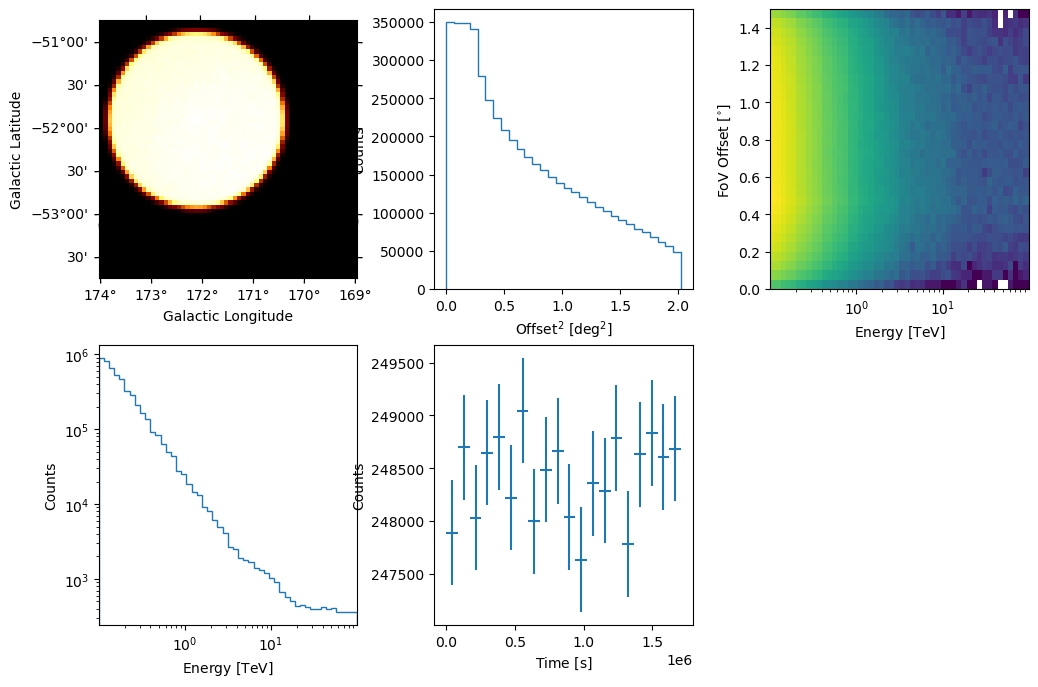

In [95]:
#We are focusing on our source
src_pos = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

#region_sky = CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)
region_sky = CircleSkyRegion(center=src_pos, radius=1 * u.deg)
evt = events.select_region(region_sky)
evt.peek()

In [96]:
# save the data into a fits file 
observation.events = events
observation.write("source_evt.fits", include_irfs=False, overwrite=True)